In [173]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [174]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [175]:
# Define the neural network for PINN
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x, t):
        input = torch.cat((x, t), dim=1)
        return self.model(input)

In [176]:
# Function to compute derivatives
def derivatives(y, x, order):
    for _ in range(order):
        y = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    return y

In [177]:
# Define the PDE loss function
def pde_loss(model, x, t, alpha):
    u = model(x, t)
    u_t = derivatives(u, t, 1)
    u_xx = derivatives(derivatives(u, x, 1), x, 1)
    residual = u_t - alpha * u_xx
    return (residual ** 2).mean()

In [178]:
# Boundary condition loss
def boundary_loss(model, x_b, t_b):
    u_pred = model(x_b, t_b)
    u_exact = torch.zeros_like(u_pred)
    return ((u_pred - u_exact) ** 2).mean()

In [179]:
# Initial condition loss
def initial_condition_loss(model, x0, t0):
    u_pred = model(x0, t0)
    u_exact = torch.sin(np.pi * x0)
    return ((u_pred - u_exact) ** 2).mean()

In [181]:
# Training parameters
alpha = 0.01  # Heat equation parameter
epochs = 1000
lr = 0.001

In [182]:
# Create grid for training
x = torch.linspace(0, 1, 100, requires_grad=True).to(device).reshape(-1, 1)
t = torch.linspace(0, 1, 100, requires_grad=True).to(device).reshape(-1, 1)
x_grid, t_grid = torch.meshgrid(x.squeeze(), t.squeeze(), indexing="ij")
x_grid = x_grid.reshape(-1, 1)
t_grid = t_grid.reshape(-1, 1)

In [183]:
# Initialize and train PINN
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [184]:
# Define initial and boundary conditions
x_b = torch.cat([torch.zeros(100, 1), torch.ones(100, 1)]).to(device)
t_b = torch.cat([t, t]).to(device)
x0 = x.to(device)
t0 = torch.zeros_like(x0).to(device)

In [185]:
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = (
        pde_loss(model, x_grid, t_grid, alpha)
        + boundary_loss(model, x_b, t_b)
        + initial_condition_loss(model, x0, t0)
    )
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

Epoch 0: Loss = 0.393975


In [186]:
# PINN solution
X, T = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X_t = torch.tensor(np.column_stack((X.ravel(), T.ravel())), dtype=torch.float32).to(device)
U_pinn = model(X_t[:, 0:1], X_t[:, 1:2]).cpu().detach().numpy().reshape(100, 100)

In [187]:
# Exact solution
U_exact = np.sin(np.pi * X) * np.exp(-np.pi**2 * alpha * T)

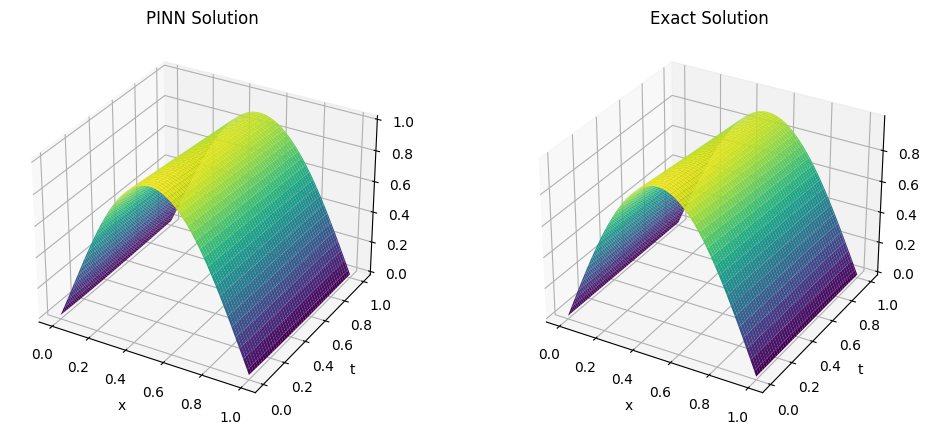

In [191]:
# Plot PINN solution
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection="3d")
ax1.plot_surface(X, T, U_pinn, cmap="viridis")
ax1.set_title("PINN Solution")
ax1.set_xlabel("x")
ax1.set_ylabel("t")

# Plot Exact solution
ax2 = fig.add_subplot(122, projection="3d")
ax2.plot_surface(X, T, U_exact, cmap="viridis")
ax2.set_title("Exact Solution")
ax2.set_xlabel("x")
ax2.set_ylabel("t")
plt.show()

In [ ]:
# Print matrix comparison
print("Matrix (x , t, PINN, Exact):")
comparison = np.column_stack((X.ravel(), T.ravel(), U_pinn.ravel(), U_exact.ravel()))
import pandas as pd
comparison_df = pd.DataFrame(comparison, columns=["x", "t", "PINN", "Exact"])
print(comparison_df)


Matrix (x '	', t, PINN, Exact):
             x    t      PINN         Exact
0     0.000000  0.0  0.004485  0.000000e+00
1     0.010101  0.0  0.033333  3.172793e-02
2     0.020202  0.0  0.062478  6.342392e-02
3     0.030303  0.0  0.091884  9.505604e-02
4     0.040404  0.0  0.121512  1.265925e-01
...        ...  ...       ...           ...
9995  0.959596  1.0  0.116859  1.146950e-01
9996  0.969697  1.0  0.087912  8.612249e-02
9997  0.979798  1.0  0.058834  5.746322e-02
9998  0.989899  1.0  0.029652  2.874608e-02
9999  1.000000  1.0  0.000396  1.109552e-16

[10000 rows x 4 columns]
